# Macro Economic Timeseries
The data is from the World Bank’s World Development Indicators. In particular, we’re pulling annual values of GDP, consumption, and gross fixed capital formation (investment) for all countries from 1970. Timeseries models in general work best when we have a stable mean throughout the series, so for the estimation procedure we have taken the first difference and the natural log of each of these series.

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

import statsmodels.api as sm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

In [3]:
pm.get_data("gdp_data_hierarchical_clean.csv")

In [4]:
try:
    gdp_hierarchical = pd.read_csv(
        os.path.join("..", "data", "gdp_data_hierarchical_clean.csv"), index_col=0
    )
except FileNotFoundError:
    gdp_hierarchical = pd.read_csv(pm.get_data("gdp_data_hierarchical_clean.csv"))

gdp_hierarchical

Unnamed: 0        country iso2c iso3c  year           GDP          CONS  \
0             1      Australia    AU   AUS  1971  4.647670e+11  3.113170e+11   
1             2      Australia    AU   AUS  1972  4.829350e+11  3.229650e+11   
2             3      Australia    AU   AUS  1973  4.955840e+11  3.371070e+11   
3             4      Australia    AU   AUS  1974  5.159300e+11  3.556010e+11   
4             5      Australia    AU   AUS  1975  5.228210e+11  3.759000e+11   
..          ...            ...   ...   ...   ...           ...           ...   
365         366  United States    US   USA  2016  1.850960e+13  1.522497e+13   
366         367  United States    US   USA  2017  1.892712e+13  1.553075e+13   
367         368  United States    US   USA  2018  1.947957e+13  1.593427e+13   
368         369  United States    US   USA  2019  1.992544e+13  1.627888e+13   
369         370  United States    US   USA  2020  1.924706e+13  1.582501e+13   

             GFCF    dl_gdp   dl_cons   dl_gfcf  more_than_10  time  
0    7.985100e+10  0.039217  0.040606  0.031705          True     1  
1    8.209200e+10  0.038346  0.036732  0.027678          True     2  
2    8.460300e+10  0.025855  0.042856  0.030129          True     3  
3    8.821400e+10  0.040234  0.053409  0.041796          True     4  
4    8.255900e+10  0.013268  0.055514 -0.066252          True     5  
..            ...       ...       ...       ...           ...   ...  
365  3.802207e+12  0.016537  0.023425  0.021058          True    44  
366  3.947418e+12  0.022306  0.019885  0.037480          True    45  
367  4.119951e+12  0.028771  0.025650  0.042780          True    46  
368  4.248643e+12  0.022631  0.021396  0.030758          True    47  
369  4.182801e+12 -0.034639 -0.028277 -0.015619          True    48  

[370 rows x 13 columns]

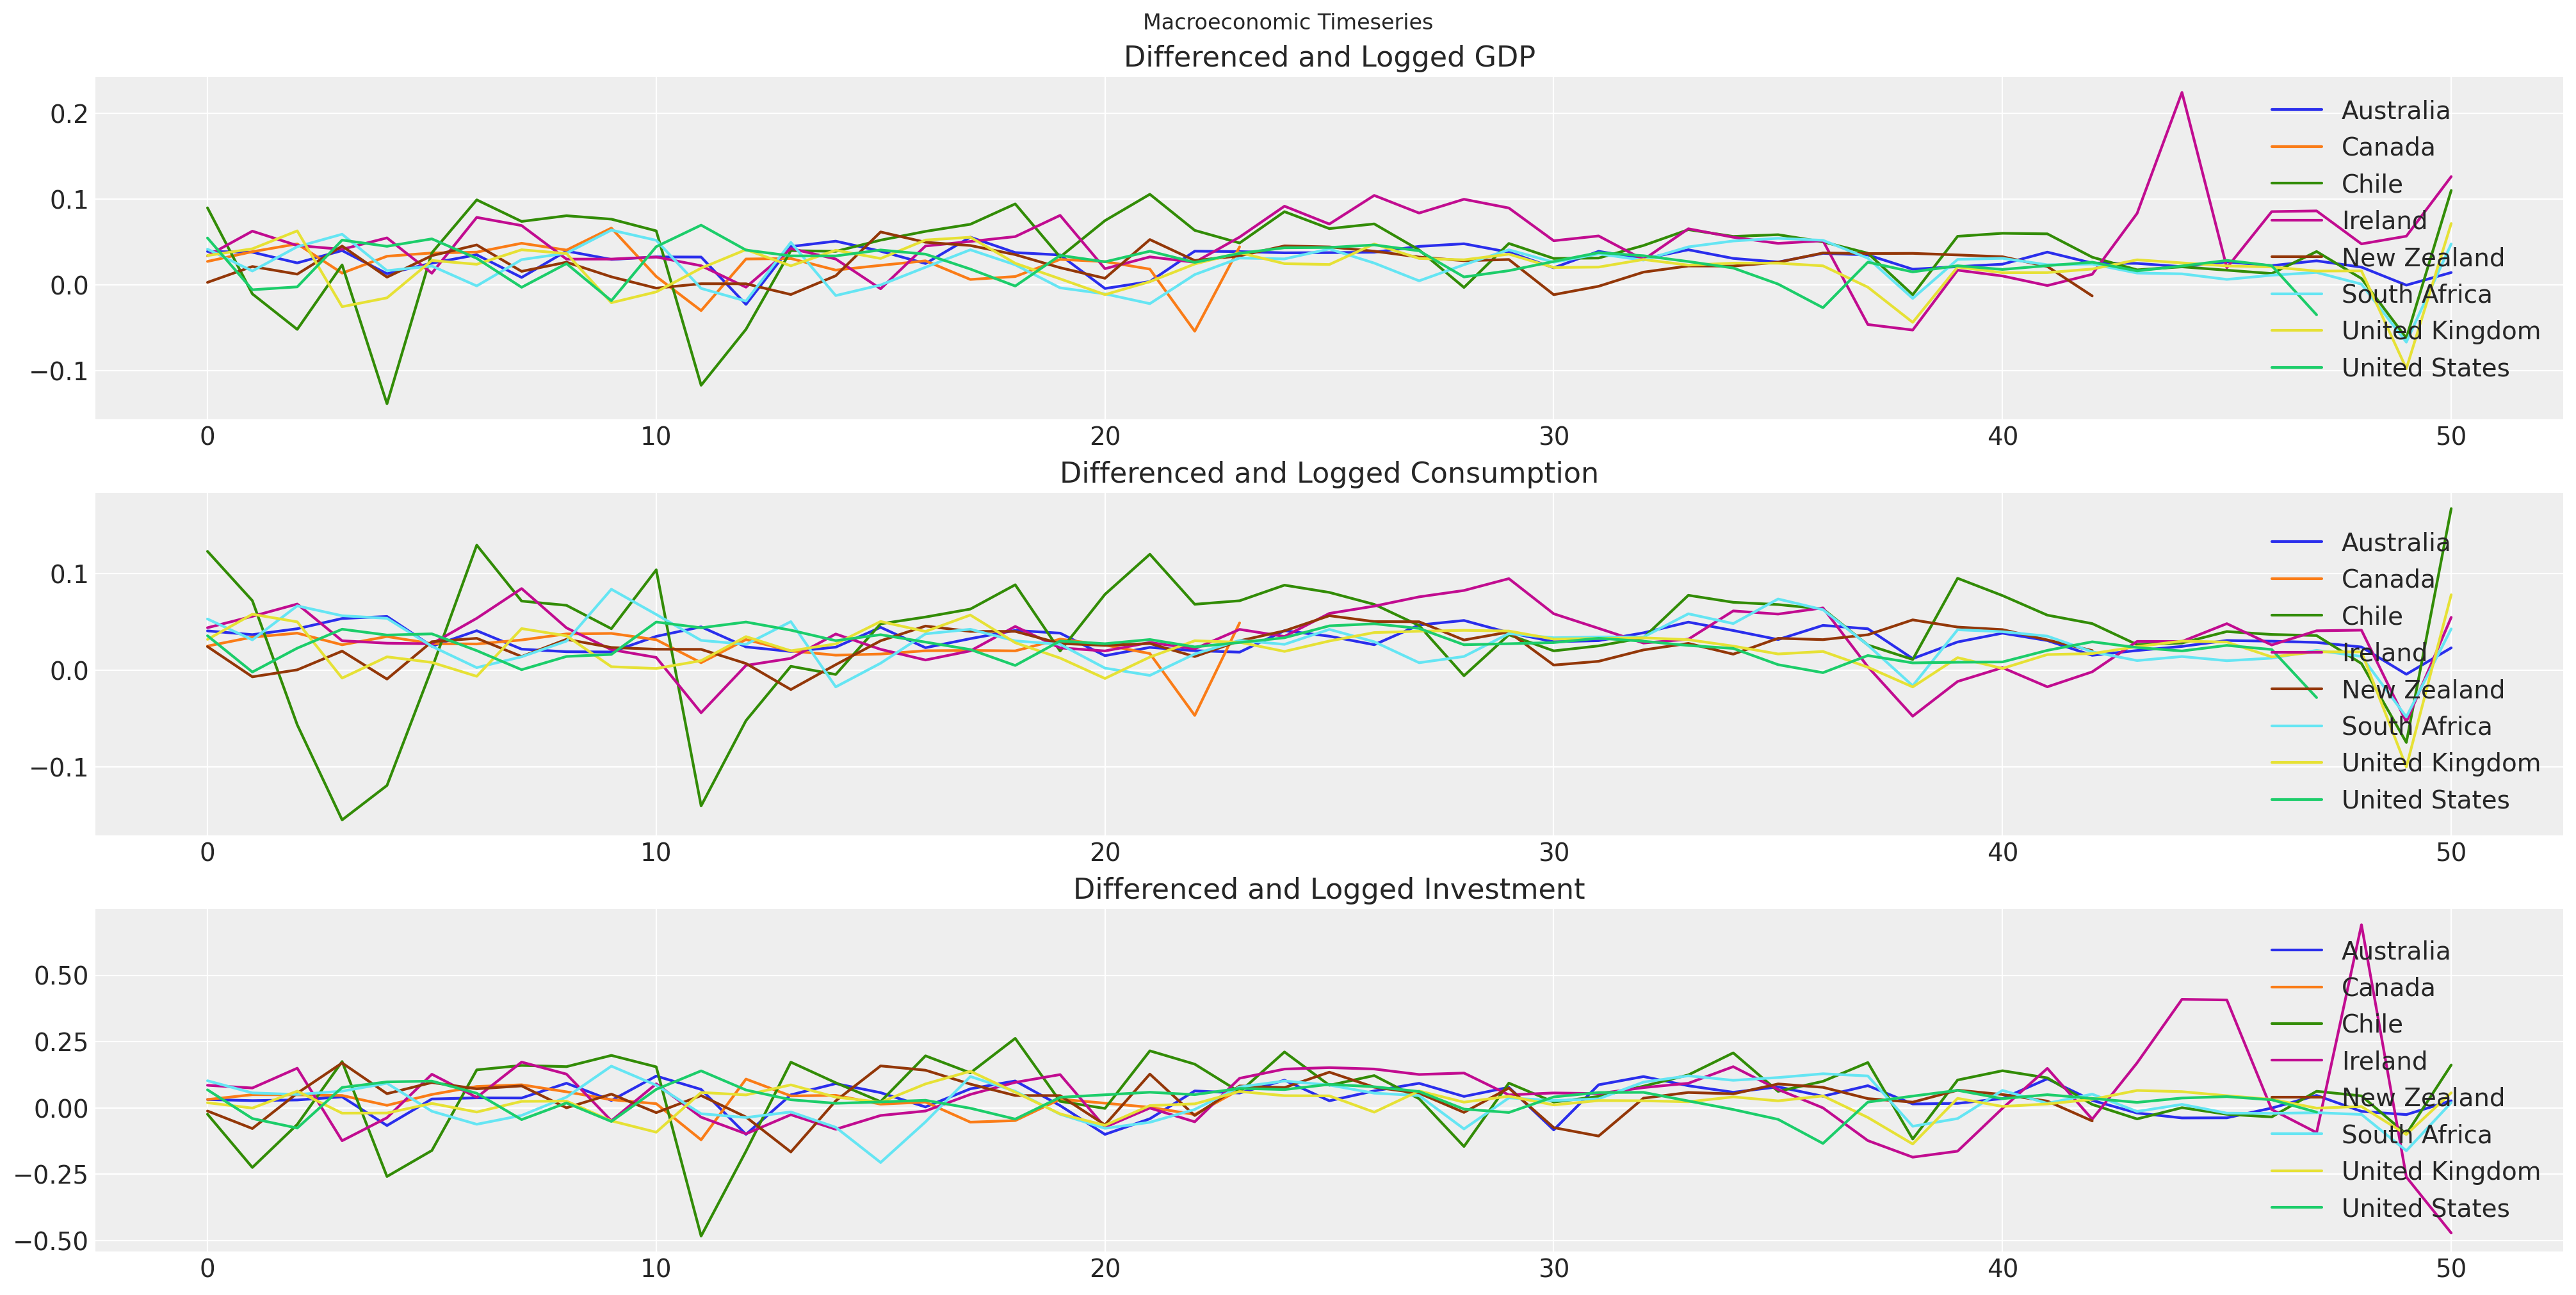

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10))
for country in gdp_hierarchical["country"].unique():
    temp = gdp_hierarchical[gdp_hierarchical["country"] == country].reset_index()
    axs[0].plot(temp["dl_gdp"], label=f"{country}")
    axs[1].plot(temp["dl_cons"], label=f"{country}")
    axs[2].plot(temp["dl_gfcf"], label=f"{country}")
axs[0].set_title("Differenced and Logged GDP")
axs[1].set_title("Differenced and Logged Consumption")
axs[2].set_title("Differenced and Logged Investment")
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.suptitle("Macroeconomic Timeseries");

Ireland is somewhat infamous for its GDP numbers that are largely the product of foreign direct investment and inflated beyond expectation in recent years by the investment and taxation deals offered to large multi-nationals. We’ll look here at just the relationship between GDP and consumption. We just want to show the mechanics of the VAR estimation, you shouldn’t read too much into the subsequent analysis.

In [6]:
ireland_df = gdp_hierarchical[gdp_hierarchical["country"] == "Ireland"]
ireland_df.reset_index(inplace=True, drop=True)
ireland_df.head()

Unnamed: 0  country iso2c iso3c  year           GDP          CONS  \
0         127  Ireland    IE   IRL  1971  3.314234e+10  2.897699e+10   
1         128  Ireland    IE   IRL  1972  3.529322e+10  3.063538e+10   
2         129  Ireland    IE   IRL  1973  3.695956e+10  3.280221e+10   
3         130  Ireland    IE   IRL  1974  3.853412e+10  3.381524e+10   
4         131  Ireland    IE   IRL  1975  4.071386e+10  3.477232e+10   

           GFCF    dl_gdp   dl_cons   dl_gfcf  more_than_10  time  
0  8.317518e+09  0.034110  0.043898  0.085452          True     1  
1  8.967782e+09  0.062879  0.055654  0.075274          True     2  
2  1.041728e+10  0.046134  0.068340  0.149828          True     3  
3  9.207243e+09  0.041720  0.030416 -0.123476          True     4  
4  8.874887e+09  0.055024  0.027910 -0.036765          True     5

In [11]:
### Define a helper function that will construct our autoregressive step for the marginal contribution of each lagged
### term in each of the respective time series equations
### Notes: this is just matrix A above.
# def calc_ar_step(lag_coefs, n_eqs, n_lags, df):
#     ars = []
#     for j in range(n_eqs):
#         ar = pm.math.sum(
#             [
#                 pm.math.sum(lag_coefs[j, i] * df.values[n_lags - (i + 1) : -(i + 1)], axis=-1)
#                 for i in range(n_lags)
#             ],
#             axis=0,
#         )
#         ars.append(ar)
#     beta = pm.math.stack(ars, axis=-1)

#     return beta

In [9]:
# ### Make the model in such a way that it can handle different specifications of the likelihood term
# ### and can be run for simple prior predictive checks. This latter functionality is important for debugging of
# ### shape handling issues. Building a VAR model involves quite a few moving parts and it is handy to
# ### inspect the shape implied in the prior predictive checks.
# def make_model(n_lags, n_eqs, df, priors, mv_norm=True, prior_checks=True):
#     coords = {
#         "lags": np.arange(n_lags) + 1,
#         "equations": df.columns.tolist(),
#         "cross_vars": df.columns.tolist(),
#         "time": [x for x in df.index[n_lags:]],
#     }

#     with pm.Model(coords=coords) as model:
#         lag_coefs = pm.Normal(
#             "lag_coefs",
#             mu=priors["lag_coefs"]["mu"],
#             sigma=priors["lag_coefs"]["sigma"],
#             dims=["equations", "lags", "cross_vars"],
#         )
#         alpha = pm.Normal(
#             "alpha", mu=priors["alpha"]["mu"], sigma=priors["alpha"]["sigma"], dims=("equations",)
#         )
#         data_obs = pm.Data("data_obs", df.values[n_lags:], dims=["time", "equations"], mutable=True)

#         betaX = calc_ar_step(lag_coefs, n_eqs, n_lags, df)
#         betaX = pm.Deterministic(
#             "betaX",
#             betaX,
#             dims=[
#                 "time",
#             ],
#         )
#         mean = alpha + betaX

#         if mv_norm:
#             n = df.shape[1]
#             ## Under the hood the LKJ prior will retain the correlation matrix too.
#             noise_chol, _, _ = pm.LKJCholeskyCov(
#                 "noise_chol",
#                 eta=priors["noise_chol"]["eta"],
#                 n=n,
#                 sd_dist=pm.HalfNormal.dist(sigma=priors["noise_chol"]["sigma"]),
#             )
#             obs = pm.MvNormal(
#                 "obs", mu=mean, chol=noise_chol, observed=data_obs, dims=["time", "equations"]
#             )
#         else:
#             ## This is an alternative likelihood that can recover sensible estimates of the coefficients
#             ## But lacks the multivariate correlation between the timeseries.
#             sigma = pm.HalfNormal("noise", sigma=priors["noise"]["sigma"], dims=["equations"])
#             obs = pm.Normal(
#                 "obs", mu=mean, sigma=sigma, observed=data_obs, dims=["time", "equations"]
#             )

#         if prior_checks:
#             idata = pm.sample_prior_predictive()
#             return model, idata
#         else:
#             idata = pm.sample_prior_predictive()
#             idata.extend(pm.sample(draws=2000, random_seed=130))
#             pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)
#     return model, idata

In [12]:
n_lags = 2
n_eqs = 2
priors = {
    ## Set prior for expected positive relationship between the variables.
    "lag_coefs": {"mu": 0.3, "sigma": 1},
    "alpha": {"mu": 0, "sigma": 0.1},
    "noise_chol": {"eta": 1, "sigma": 1},
    "noise": {"sigma": 1},
}
model, idata_ireland = make_model(
    n_lags, n_eqs, ireland_df[["dl_gdp", "dl_cons"]], priors, prior_checks=False
)
idata_ireland

Sampling: [alpha, lag_coefs, noise_chol, obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lag_coefs, alpha, noise_chol]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 166 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [obs]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

/opt/conda/lib/python3.10/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  


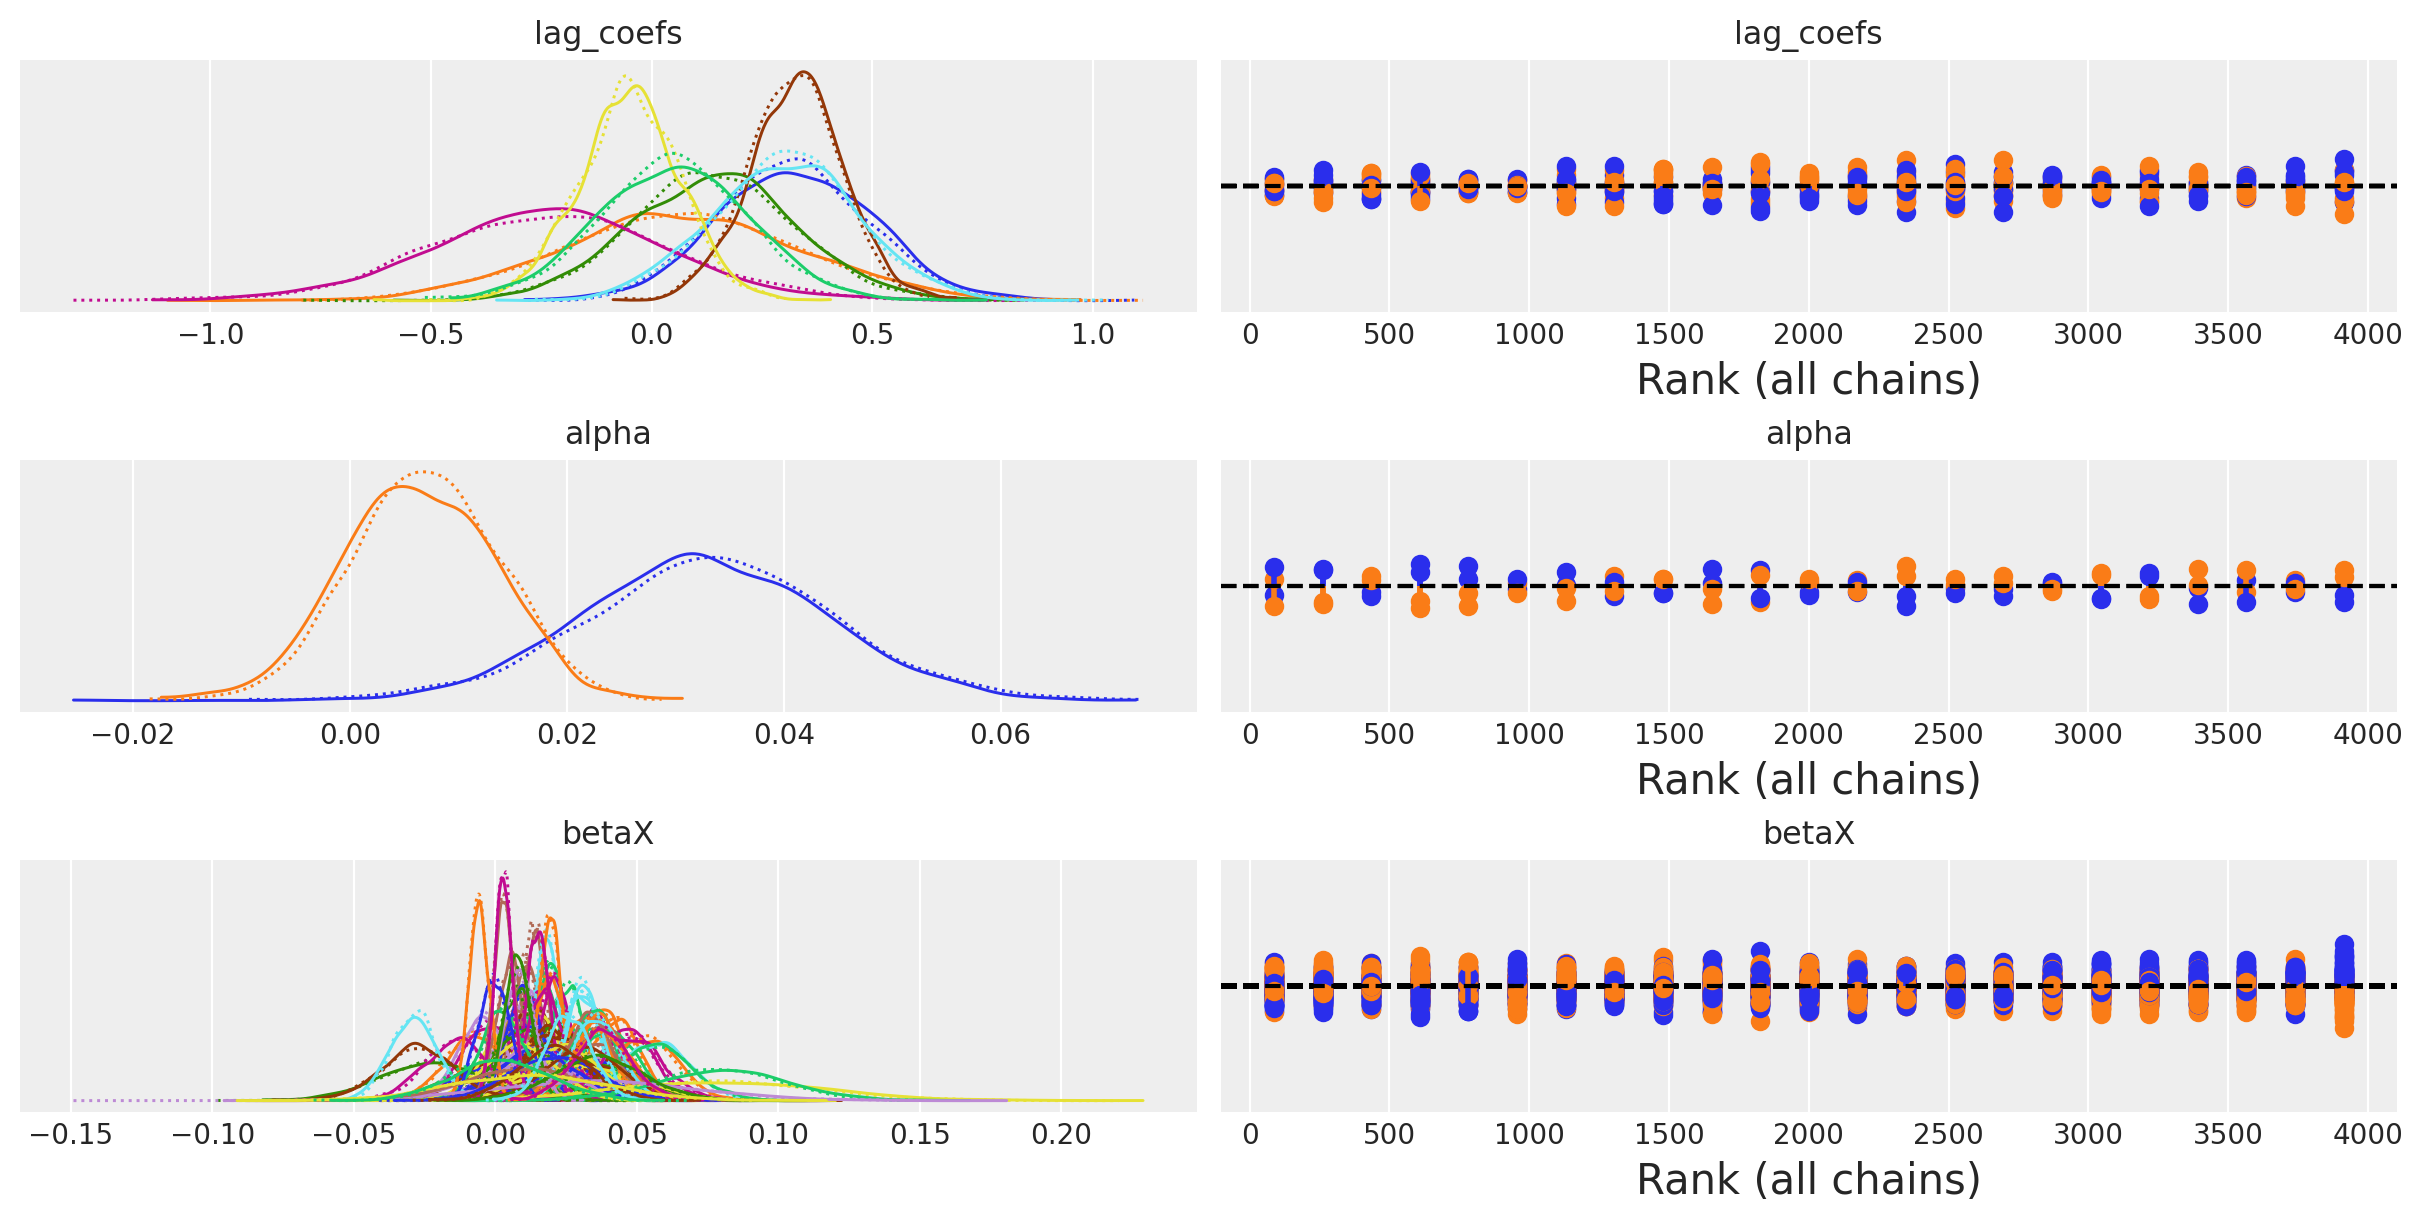

In [17]:
az.plot_trace(idata_ireland, var_names=["lag_coefs", "alpha", "betaX"], kind="rank_vlines");

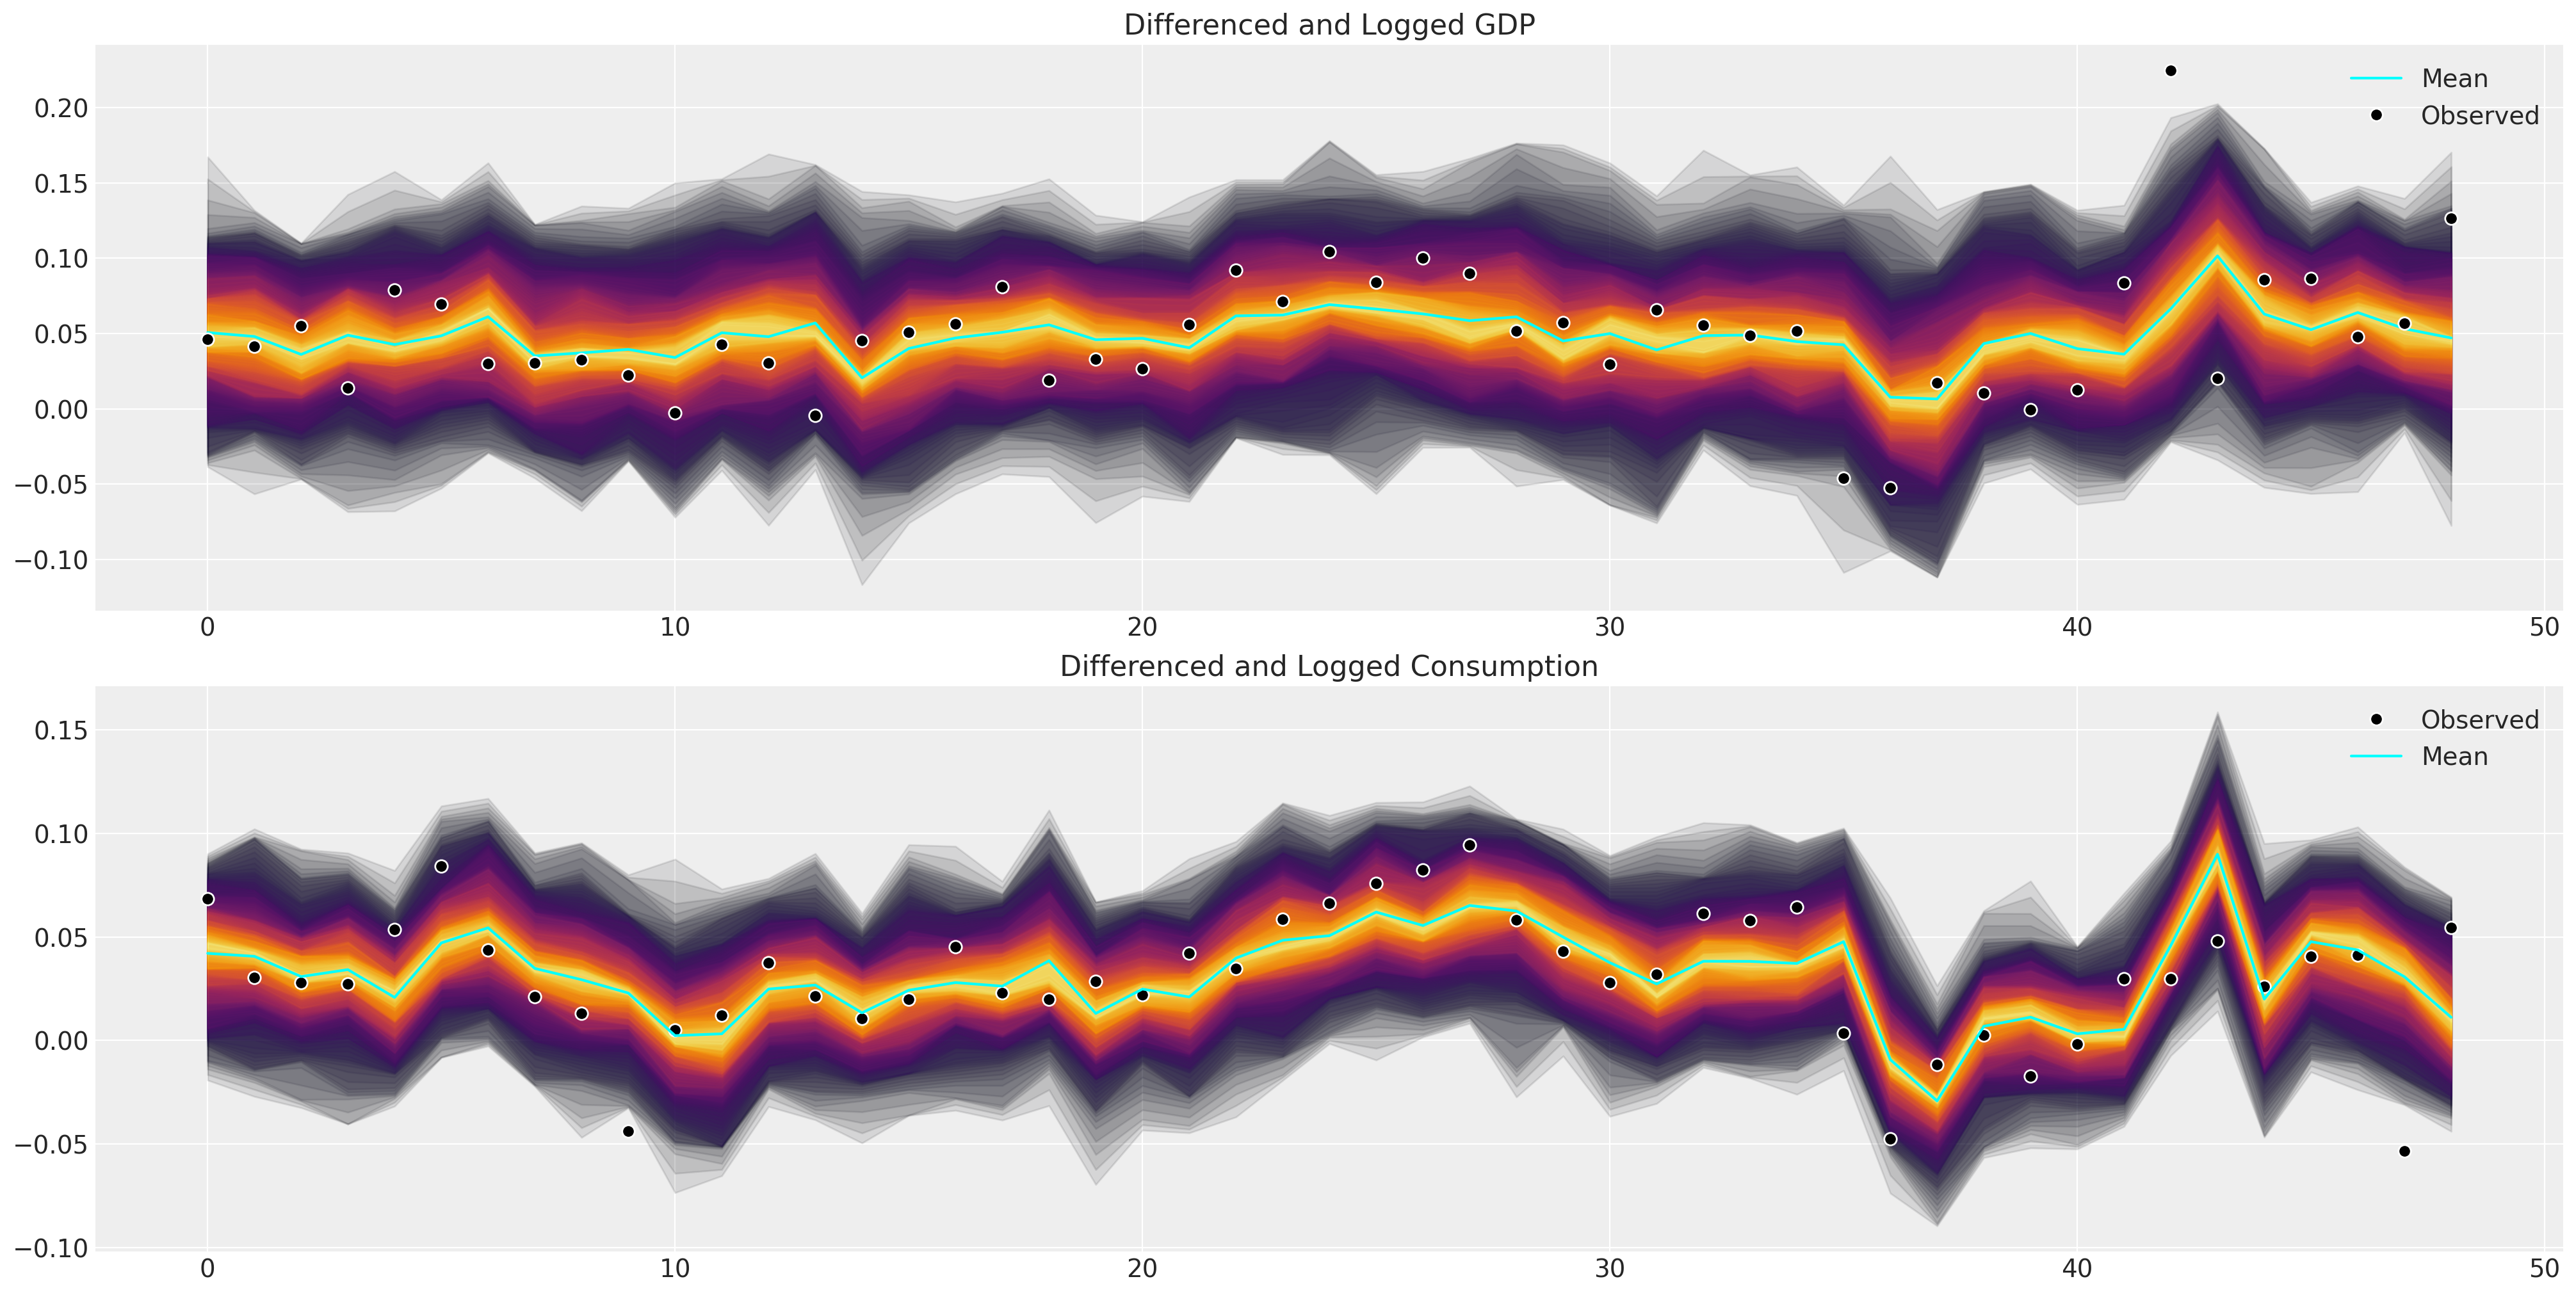

In [22]:
def shade_background(ppc, ax, idx, palette="cividis"):
    palette = palette
    cmap = plt.get_cmap(palette)
    percs = np.linspace(51, 99, 100)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(
            ppc[:, idx, :],
            p,
            axis=1,
        )
        lower = np.percentile(
            ppc[:, idx, :],
            100 - p,
            axis=1,
        )
        color_val = colors[i]
        ax[idx].fill_between(
            x=np.arange(ppc.shape[0]),
            y1=upper.flatten(),
            y2=lower.flatten(),
            color=cmap(color_val),
            alpha=0.1,
        )

def plot_ppc_macro(idata, df, group="posterior_predictive"):
    df = pd.DataFrame(idata["observed_data"]["obs"].data, columns=["dl_gdp", "dl_cons"])
    fig, axs = plt.subplots(2, 1, figsize=(20, 10))
    axs = axs.flatten()
    ppc = az.extract_dataset(idata, group=group, num_samples=100)["obs"]

    shade_background(ppc, axs, 0, "inferno")
    axs[0].plot(np.arange(ppc.shape[0]), ppc[:, 0, :].mean(axis=1), color="cyan", label="Mean")
    axs[0].plot(df["dl_gdp"], "o", mfc="black", mec="white", mew=1, markersize=7, label="Observed")
    axs[0].set_title("Differenced and Logged GDP")
    axs[0].legend()
    shade_background(ppc, axs, 1, "inferno")
    axs[1].plot(df["dl_cons"], "o", mfc="black", mec="white", mew=1, markersize=7, label="Observed")
    axs[1].plot(np.arange(ppc.shape[0]), ppc[:, 1, :].mean(axis=1), color="cyan", label="Mean")
    axs[1].set_title("Differenced and Logged Consumption")
    axs[1].legend()


plot_ppc_macro(idata_ireland, ireland_df)

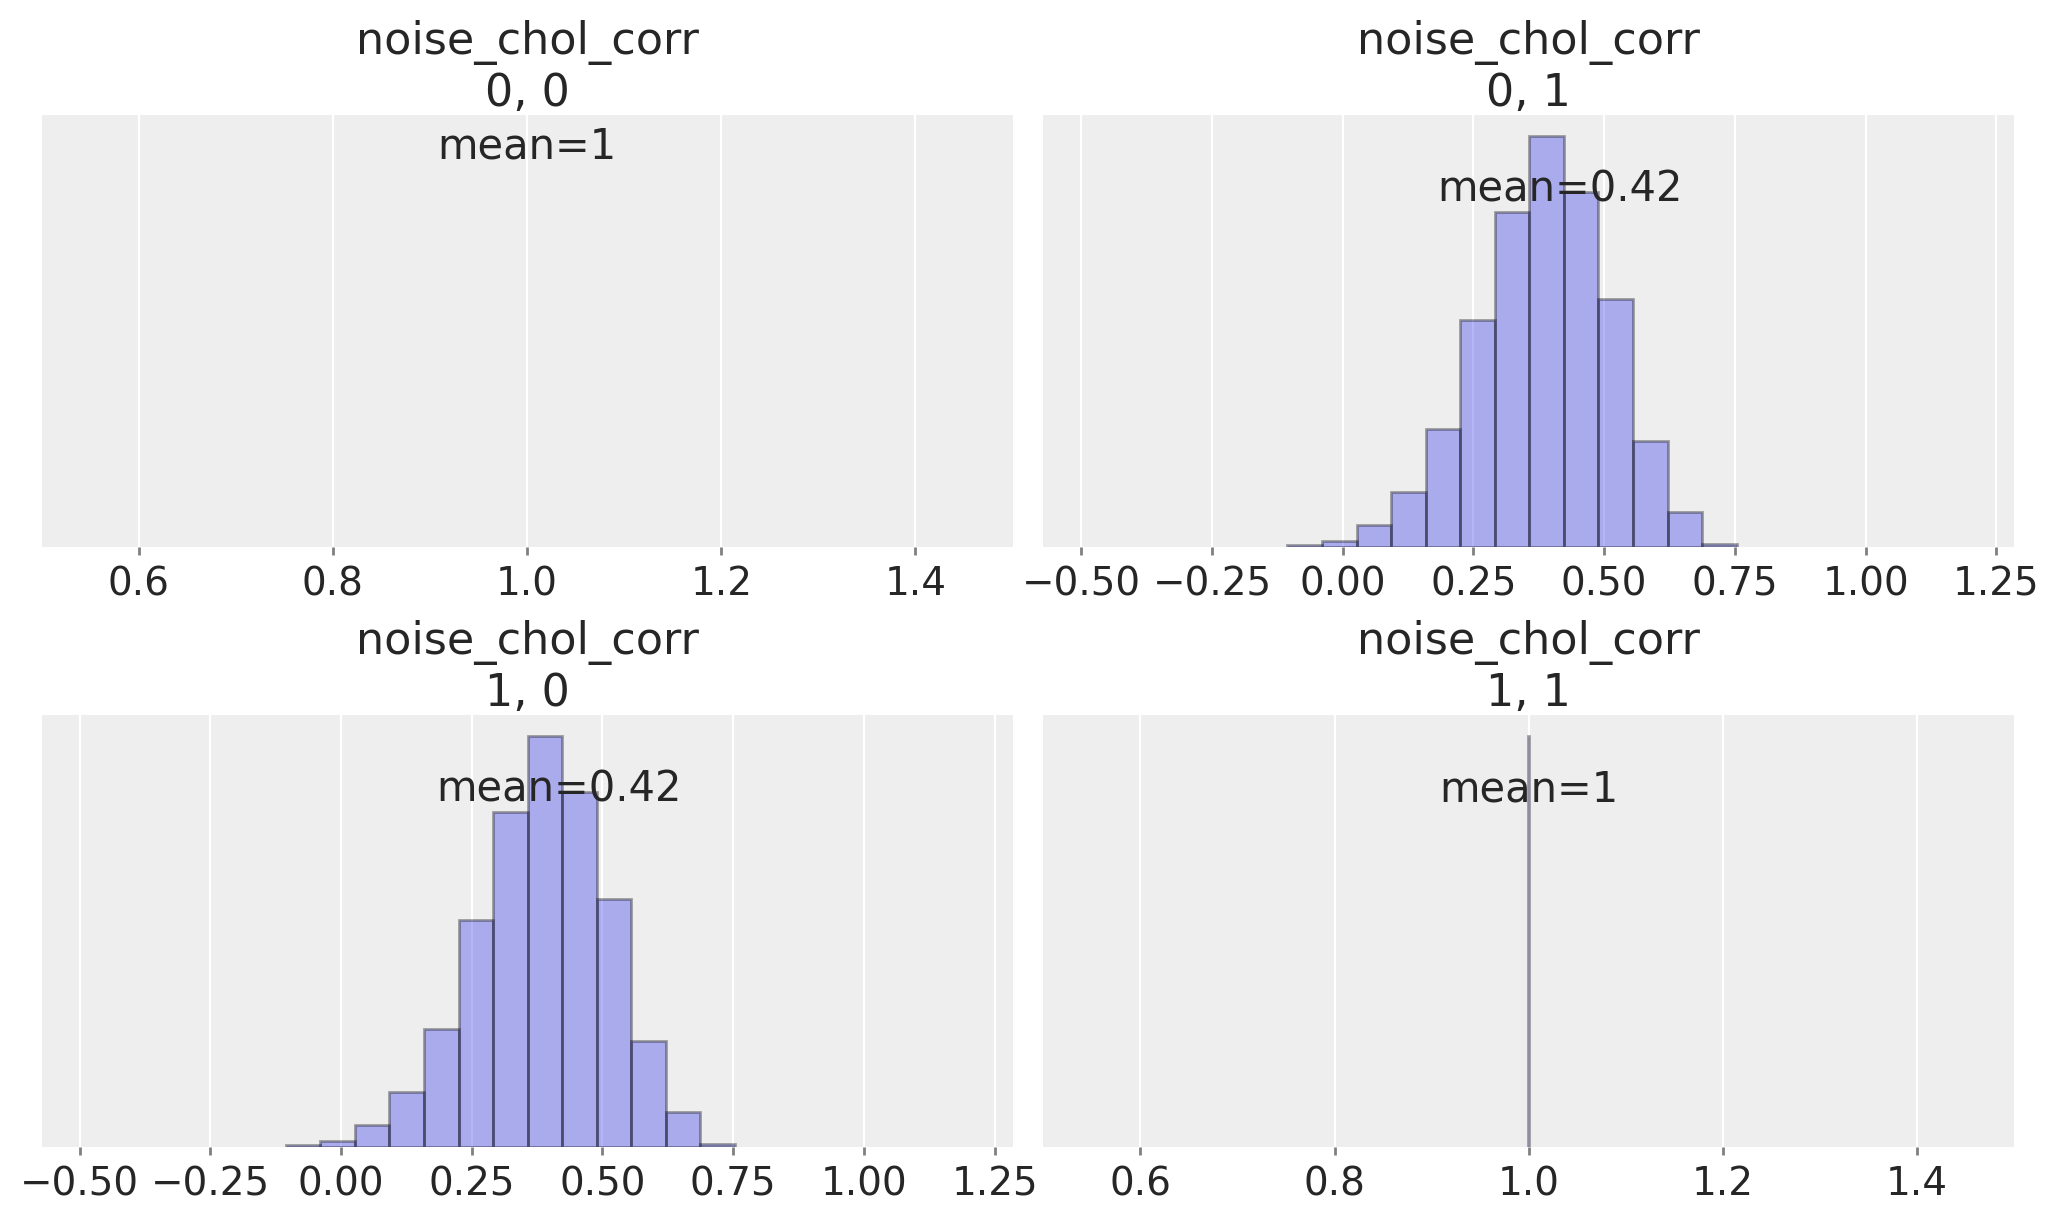

In [23]:
ax = az.plot_posterior(
    idata_ireland,
    var_names="noise_chol_corr",
    hdi_prob="hide",
    point_estimate="mean",
    grid=(2, 2),
    kind="hist",
    ec="black",
    figsize=(10, 6),
)

# Heirarchical BVARs

In addition we can add some hierarchical parameters if we want to model multiple countries and the relationship between these economic metrics at the national level. This is a useful technique in the cases where we have reasonably short timeseries data because it allows us to “borrow” information across the countries to inform the estimates of the key parameters.

In [24]:
def make_hierarchical_model(n_lags, n_eqs, df, group_field, prior_checks=True):
    cols = [col for col in df.columns if col != group_field]
    coords = {"lags": np.arange(n_lags) + 1, "equations": cols, "cross_vars": cols}

    groups = df[group_field].unique()

    with pm.Model(coords=coords) as model:
        ## Hierarchical Priors
        rho = pm.Beta("rho", alpha=2, beta=2)
        alpha_hat_location = pm.Normal("alpha_hat_location", 0, 0.1)
        alpha_hat_scale = pm.InverseGamma("alpha_hat_scale", 3, 0.5)
        beta_hat_location = pm.Normal("beta_hat_location", 0, 0.1)
        beta_hat_scale = pm.InverseGamma("beta_hat_scale", 3, 0.5)
        omega_global, _, _ = pm.LKJCholeskyCov(
            "omega_global", n=n_eqs, eta=1.0, sd_dist=pm.Exponential.dist(1)
        )

        for grp in groups:
            df_grp = df[df[group_field] == grp][cols]
            z_scale_beta = pm.InverseGamma(f"z_scale_beta_{grp}", 3, 0.5)
            z_scale_alpha = pm.InverseGamma(f"z_scale_alpha_{grp}", 3, 0.5)
            lag_coefs = pm.Normal(
                f"lag_coefs_{grp}",
                mu=beta_hat_location,
                sigma=beta_hat_scale * z_scale_beta,
                dims=["equations", "lags", "cross_vars"],
            )
            alpha = pm.Normal(
                f"alpha_{grp}",
                mu=alpha_hat_location,
                sigma=alpha_hat_scale * z_scale_alpha,
                dims=("equations",),
            )

            betaX = calc_ar_step(lag_coefs, n_eqs, n_lags, df_grp)
            betaX = pm.Deterministic(f"betaX_{grp}", betaX)
            mean = alpha + betaX

            n = df_grp.shape[1]
            noise_chol, _, _ = pm.LKJCholeskyCov(
                f"noise_chol_{grp}", eta=10, n=n, sd_dist=pm.Exponential.dist(1)
            )
            omega = pm.Deterministic(f"omega_{grp}", rho * omega_global + (1 - rho) * noise_chol)
            obs = pm.MvNormal(f"obs_{grp}", mu=mean, chol=omega, observed=df_grp.values[n_lags:])

        if prior_checks:
            idata = pm.sample_prior_predictive()
            return model, idata
        else:
            idata = pm.sample_prior_predictive()
            idata.extend(sample_blackjax_nuts(2000, random_seed=120))
            pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    return model, idata

The model design allows for a non-centred parameterisation of the key likeihood for each of the individual country components by allowing the us to shift the country specific estimates away from the hierarchical mean. This is done by rho * omega_global + (1 - rho) * noise_chol line. The parameter rho determines the share of impact each country’s data contributes to the estimation of the covariance relationship among the economic variables. Similar country specific adjustments are made with the z_alpha_scale and z_beta_scale parameters.

In [25]:
df_final = gdp_hierarchical[["country", "dl_gdp", "dl_cons", "dl_gfcf"]]
model_full_test, idata_full_test = make_hierarchical_model(
    2,
    3,
    df_final,
    "country",
    prior_checks=False,
)

Sampling: [alpha_Australia, alpha_Canada, alpha_Chile, alpha_Ireland, alpha_New Zealand, alpha_South Africa, alpha_United Kingdom, alpha_United States, alpha_hat_location, alpha_hat_scale, beta_hat_location, beta_hat_scale, lag_coefs_Australia, lag_coefs_Canada, lag_coefs_Chile, lag_coefs_Ireland, lag_coefs_New Zealand, lag_coefs_South Africa, lag_coefs_United Kingdom, lag_coefs_United States, noise_chol_Australia, noise_chol_Canada, noise_chol_Chile, noise_chol_Ireland, noise_chol_New Zealand, noise_chol_South Africa, noise_chol_United Kingdom, noise_chol_United States, obs_Australia, obs_Canada, obs_Chile, obs_Ireland, obs_New Zealand, obs_South Africa, obs_United Kingdom, obs_United States, omega_global, rho, z_scale_alpha_Australia, z_scale_alpha_Canada, z_scale_alpha_Chile, z_scale_alpha_Ireland, z_scale_alpha_New Zealand, z_scale_alpha_South Africa, z_scale_alpha_United Kingdom, z_scale_alpha_United States, z_scale_beta_Australia, z_scale_beta_Canada, z_scale_beta_Chile, z_scale_

NameError: name 'sample_blackjax_nuts' is not defined

In [ ]:
idata_full_test